In [1]:
import gym
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.activations import relu, linear
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Условия окружения

LunarLander-v2
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Инициализируем окружение

In [2]:
env = gym.make('LunarLander-v2')

/home/obi-1-konobe/projects/mag/ml/task_6/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Состояния описываются 8 параметрами

In [3]:
env.observation_space

Box(8,)

Существует 4 варианта действий

In [4]:
env.action_space.n

4

Инициализируем гиперпараметры

In [17]:
lr = 0.001
state_size = 8
n_actions = 4
exp_bufer = list()
epsilon = 1
min_epsilon = 0.1
gamma = 0.99
batch_size = 100

Инициализируем нейронную сеть

In [18]:
model = Sequential()
model.add(Dense(256, input_dim=state_size, activation=relu))
model.add(Dense(128, activation=relu))
model.add(Dense(n_actions, activation=linear))
model.compile(loss='mse', optimizer=adam(lr=lr))

Функция выбора действия по состоянию

In [19]:
def get_action(state):
    # exploartion vs explotation
    exploration_explotation =  random.random()
    if exploration_explotation < epsilon:
        random_action = env.action_space.sample()
        return random_action
    best_action = np.argmax(model.predict(state)[0])
    return best_action

Функция обновления весов сети

In [20]:
def update_weights():
    # набирвем батч из буфера
    batch = random.sample(exp_bufer, batch_size)
    # рассчитываем значения Q-функции 
    states = np.array([i[0] for i in batch])
    actions = np.array([i[1] for i in batch])
    rewards = np.array([i[2] for i in batch])
    next_states = np.array([i[3] for i in batch])
    dones = np.array([i[4] for i in batch])
    
    states = np.squeeze(states)
    next_states = np.squeeze(next_states)
    
    targets = rewards + gamma*(np.amax(model.predict_on_batch(next_states), axis=1))*(1-dones)
    # подставляем новые значения Q-функции
    targets_full = model.predict_on_batch(states)
    ind = np.array([i for i in range(batch_size)])
    targets_full[[ind], [actions]] = targets
    # обновляем веса сети
    model.fit(states, targets_full, epochs=1, verbose=0)

Запускаем 10 эпизодов со случайными действиями для первичного заполнения буфера

In [21]:
for i in range(10):
    done = False
    state = env.reset()
    while not done:
        state = np.reshape(state, (1, 8))
        random_action = env.action_space.sample()
        env.render()
        next_state, reward, done, info = env.step(random_action)
        next_state = np.reshape(next_state, (1, 8))
        exp_bufer.append((state, random_action, reward, next_state, done))
        state = next_state
    
env.close()
print(len(exp_bufer))

1031


Тренируем нейронную сеть

In [22]:
episodes_score = list()
counter = 0
for episode in range(2000):
    state = env.reset()
    state = np.reshape(state, (1, state_size))
    cumulative_rewards = 0
    max_steps = 1500
    for i in range(max_steps):
        # выбираем действие
        action = get_action(state)
        # получаем новые параметры и сохраняем их в буфер
        env.render()
        next_state, reward, done, info = env.step(action)
        cumulative_rewards += reward
        next_state = np.reshape(next_state, (1, state_size))
        exp_bufer.append((state, action, reward, next_state, done))
        state = next_state
        # обновляем веса
        update_weights()
        # если эпизод закончился
        if done:
            print(f'episode {episode} score {cumulative_rewards} counter {counter}')
            # уменьшаем exploration
            if epsilon > min_epsilon:
                epsilon -= 0.01
            break
    # если последние 50 эпизодов закончились успешно, то дострочно прекращаем обучение 
    episodes_score.append(cumulative_rewards)
#     if np.mean(episodes_score[-50:]) > 200:
    if cumulative_rewards < 0:
        counter = 0
        continue
    counter += 1
    if counter >= 100:
        print('finish')
        break


episode 0 score -242.34474202715327 counter 0
episode 1 score -72.32734681781386 counter 0
episode 2 score -193.7383728240706 counter 0
episode 3 score -247.14801115995317 counter 0
episode 4 score -191.08776275579254 counter 0
episode 5 score -163.89467627842407 counter 0
episode 6 score -119.43864802786024 counter 0
episode 7 score -100.87027168007934 counter 0
episode 8 score -164.6670072831631 counter 0
episode 9 score -71.53388885636969 counter 0
episode 10 score -108.86679074916371 counter 0
episode 11 score -97.25701254700441 counter 0
episode 12 score -63.41245271343672 counter 0
episode 13 score -183.85595492329287 counter 0
episode 14 score -152.0935019952559 counter 0
episode 15 score -132.02420126401682 counter 0
episode 16 score -101.76039653768568 counter 0
episode 17 score -167.5302377186264 counter 0
episode 18 score -94.24785656301052 counter 0
episode 19 score -84.44186815755825 counter 0
episode 20 score -78.32502670869258 counter 0
episode 21 score -55.5423082182750

episode 176 score 227.0969049461487 counter 25
episode 177 score 172.6191429648518 counter 26
episode 178 score 114.8502377371649 counter 27
episode 179 score 223.01356615321012 counter 28
episode 180 score 114.67500350988334 counter 29
episode 181 score -54.72425190858685 counter 30
episode 182 score 2.6453088025183007 counter 0
episode 183 score 186.09060932555778 counter 1
episode 184 score 254.04661354965674 counter 2
episode 185 score -87.79889365816798 counter 3
episode 186 score -292.31479445387544 counter 0
episode 187 score 148.80972324381807 counter 0
episode 188 score 6.231076757520839 counter 1
episode 189 score 249.3546593572827 counter 2
episode 190 score -208.2182502193891 counter 3
episode 191 score 247.43003628093788 counter 0
episode 192 score 234.14983541325745 counter 1
episode 193 score 171.98335850869572 counter 2
episode 194 score -160.7616871004082 counter 3
episode 195 score 178.68428417907018 counter 0
episode 196 score 239.55225106963806 counter 1
episode 197

episode 351 score 241.08226211351325 counter 9
episode 352 score 248.45961205916234 counter 10
episode 353 score 287.8551525610585 counter 11
episode 354 score -57.52728750638425 counter 12
episode 355 score 282.9777099779879 counter 0
episode 356 score 10.159496530803253 counter 1
episode 357 score 219.37677924875405 counter 2
episode 358 score 271.6256553017051 counter 3
episode 359 score -82.27744962483017 counter 4
episode 360 score 267.2898804089467 counter 0
episode 361 score 260.7491341220116 counter 1
episode 362 score 210.23907928831954 counter 2
episode 363 score -209.90191290058942 counter 3
episode 364 score 221.8366568724527 counter 0
episode 365 score 215.75148532892598 counter 1
episode 366 score 247.83209459555766 counter 2
episode 367 score 261.3363756195662 counter 3
episode 368 score -117.08245906282727 counter 4
episode 369 score -207.29666093384216 counter 0
episode 370 score -531.2655244407056 counter 0
episode 371 score -275.3757909680148 counter 0
episode 372 sc

episode 526 score -266.55245271156537 counter 0
episode 527 score -180.76716024102478 counter 0
episode 528 score 151.46607462519324 counter 0
episode 529 score 207.4801282061804 counter 1
episode 530 score 204.55896026158172 counter 2
episode 531 score -194.91669776665623 counter 3
episode 532 score -108.28097977319553 counter 0
episode 533 score -102.71786952927995 counter 0
episode 534 score 190.59561388999293 counter 0
episode 535 score -276.19403794882373 counter 1
episode 536 score -38.81429055068324 counter 0
episode 537 score 204.69183572243674 counter 0
episode 538 score -113.20036543370057 counter 1
episode 539 score -9.713323004777038 counter 0
episode 540 score -271.3879244424206 counter 0
episode 541 score 234.95700421044074 counter 0
episode 542 score 113.81176751413264 counter 1
episode 543 score 280.8351870044859 counter 2
episode 544 score 185.76913268209876 counter 3
episode 545 score -131.32225818197324 counter 4
episode 546 score -11.08086368979049 counter 0
episode

episode 700 score 243.28869628704916 counter 0
episode 701 score 281.3576603536509 counter 1
episode 702 score 285.0980937284275 counter 2
episode 703 score 284.30713365190115 counter 3
episode 704 score 246.24347152567768 counter 4
episode 705 score 242.20773925346109 counter 5
episode 706 score 250.32283451016679 counter 6
episode 707 score 249.66833095094725 counter 7
episode 708 score 260.70638394971235 counter 8
episode 709 score 268.0196811465476 counter 9
episode 710 score 260.7107076728906 counter 10
episode 711 score 156.25921921446061 counter 11
episode 712 score 251.65302513134154 counter 12
episode 713 score 273.0589682067397 counter 13
episode 714 score 263.8038001667732 counter 14
episode 715 score -216.77988761467236 counter 15
episode 716 score 231.7984520555954 counter 0
episode 717 score 226.70130368979906 counter 1
episode 718 score 288.34120043729484 counter 2
episode 719 score 293.888586351966 counter 3
episode 720 score 258.87031354244334 counter 4
episode 721 sco

episode 874 score -624.5038936501381 counter 0
episode 875 score -25.403379956915515 counter 0
episode 876 score -565.3273873232193 counter 0
episode 877 score -125.05172068997837 counter 0
episode 878 score -3.4820685362399644 counter 0
episode 879 score -135.30395545929719 counter 0
episode 880 score -108.24796479633864 counter 0
episode 881 score 26.485704768289 counter 0
episode 882 score 112.18545598908435 counter 1
episode 883 score 211.9834448436165 counter 2
episode 884 score 213.89067815937625 counter 3
episode 885 score 262.35628086079055 counter 4
episode 886 score 188.9380913757284 counter 5
episode 887 score -393.5477368717536 counter 6
episode 888 score 235.5137598796096 counter 0
episode 889 score 243.80084493692016 counter 1
episode 890 score 18.678549014855918 counter 2
episode 891 score -151.33019448908462 counter 3
episode 892 score 229.58747639754 counter 0
episode 893 score -172.58486154929062 counter 1
episode 894 score 103.01692885783251 counter 0
episode 895 sco

episode 1047 score 177.61863608015886 counter 33
episode 1048 score 302.83224576414744 counter 34
episode 1049 score 255.71896980525042 counter 35
episode 1050 score 125.16572956694279 counter 36
episode 1051 score 180.31785410902114 counter 37
episode 1052 score 202.48647916532352 counter 38
episode 1053 score 265.60827335462056 counter 39
episode 1054 score 250.51608100666397 counter 40
episode 1055 score 196.33552470748458 counter 41
episode 1056 score 249.2299530111188 counter 42
episode 1057 score 148.5284714577125 counter 43
episode 1058 score 257.06706606345415 counter 44
episode 1059 score 263.95894576014774 counter 45
episode 1060 score 238.1707060071774 counter 46
episode 1061 score 269.38065832280006 counter 47
episode 1062 score 116.71383711089126 counter 48
episode 1063 score 148.7648816702547 counter 49
episode 1064 score 216.4905690572886 counter 50
episode 1065 score -27.332927319668258 counter 51
episode 1066 score 248.0933898267054 counter 0
episode 1067 score 283.924

episode 1217 score 223.61010148760752 counter 27
episode 1218 score 294.0940857860418 counter 28
episode 1219 score 204.75977170620385 counter 29
episode 1220 score 227.89257733765908 counter 30
episode 1221 score 243.03836659050364 counter 31
episode 1222 score 254.480915021523 counter 32
episode 1223 score 227.72693824755783 counter 33
episode 1224 score 214.14575364314308 counter 34
episode 1225 score 237.04963805271964 counter 35
episode 1226 score 266.1414620076777 counter 36
episode 1227 score 245.7406784463708 counter 37
episode 1228 score 232.53204113926742 counter 38
episode 1229 score 251.34082509697885 counter 39
episode 1230 score 238.89431880249882 counter 40
episode 1231 score 219.97188139885364 counter 41
episode 1232 score 223.9046755108045 counter 42
episode 1233 score 261.5229742621211 counter 43
episode 1234 score 258.5173090113518 counter 44
episode 1235 score 260.916954504899 counter 45
episode 1236 score 214.47109025004374 counter 46
episode 1237 score 235.5365319

In [42]:
env.close()

Кривая обучения

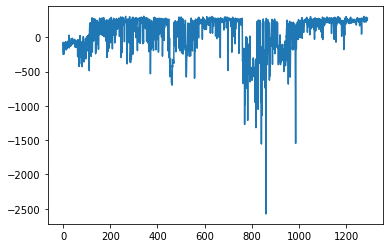

In [24]:
plt.plot(episodes_score)

Тестируем модель

In [41]:
test_score = list()
for i in range(100):
    done = False
    state = env.reset()
    score = 0
    while not done:
    
        state = np.reshape(state, (1, 8))
        action = np.argmax(model.predict(state)[0])
        env.render()
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    test_score.append(score)
env.close()

KeyboardInterrupt: 

Кривая теста

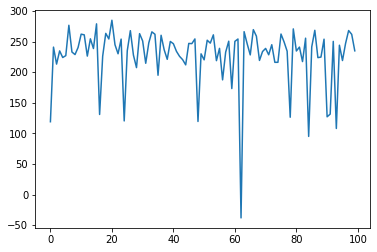

In [26]:
plt.plot(test_score)

Гистограмма

In [33]:
a = len([x for x in test_score if x < 0])
b = len([x for x in test_score if 0 <= x < 100])
c = len([x for x in test_score if 100 <= x < 200])
d = len([x for x in test_score if x > 200])

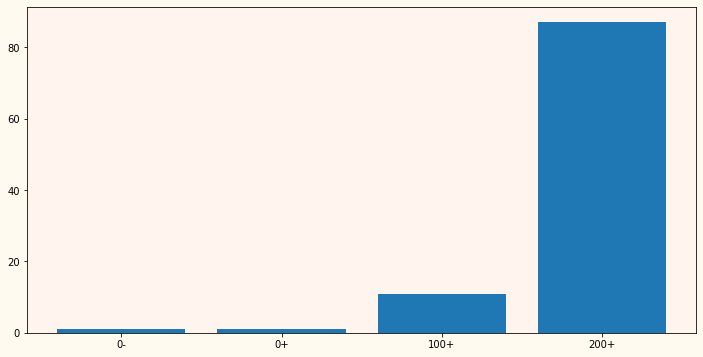

1 1 11 87


In [40]:
x = ['0-', '0+', '100+', '200+']
y = [a, b, c, d]

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()
print(a, b, c, d)

87% прилунений закончились удачно (>200)